## **Dependencies**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC 
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier

from imblearn.combine import SMOTETomek # because our data is unbalanced

random_state = 42
np.random.seed(random_state)


## **Data Processing**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [3]:
dat_nurse = pd.read_csv('./prepared_1061.csv')

In [4]:
dat_nurse.head()

,HADM_ID,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,...,ROW_ID,SUBJECT_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,100213,1,100213,0.0,74,2,26.81457,1,0,0,...,1170971,85723,2154-02-13,2154-02-13 00:49:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2154-2-13**] 12:49 AM\n CHEST (PORTABLE AP)...
1,100449,2,100449,0.0,87,1,24.00000,1,0,0,...,1203496,77177,2137-08-16,2137-08-16 08:11:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2137-8-16**] 8:11 AM\n CHEST (PORTABLE AP) ...
2,100571,1,100571,0.0,67,1,32.28435,1,0,0,...,1058554,99008,2173-02-19,2173-02-19 19:18:00,2173-02-20 06:44:48,Radiology,CHEST (PORTABLE AP),18928.0,NaN,[**2173-2-19**] 7:18 PM\n CHEST (PORTABLE AP) ...
3,100610,1,100610,0.0,81,2,NaN,1,1,0,...,1221573,68674,2136-12-19,2136-12-19 16:32:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2136-12-19**] 4:32 PM\n CHEST (PORTABLE AP)...
4,100660,1,100660,0.0,75,1,NaN,1,0,0,...,948144,631,2124-01-23,2124-01-23 13:11:00,2124-01-23 14:07:00,Radiology,CHEST (PORTABLE AP),15597.0,NaN,[**2124-1-23**] 1:11 PM\n CHEST (PORTABLE AP) ...


In [5]:
dat_nurse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   HADM_ID                   1061 non-null   int64  
 1   group                     1061 non-null   int64  
 2   ID                        1061 non-null   int64  
 3   outcome                   1060 non-null   float64
 4   age                       1061 non-null   int64  
 5   gendera                   1061 non-null   int64  
 6   BMI                       865 non-null    float64
 7   hypertensive              1061 non-null   int64  
 8   atrialfibrillation        1061 non-null   int64  
 9   CHD with no MI            1061 non-null   int64  
 10  diabetes                  1061 non-null   int64  
 11  deficiencyanemias         1061 non-null   int64  
 12  depression                1061 non-null   int64  
 13  Hyperlipemia              1061 non-null   int64  
 14  Renal fa

(array([921.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 139.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

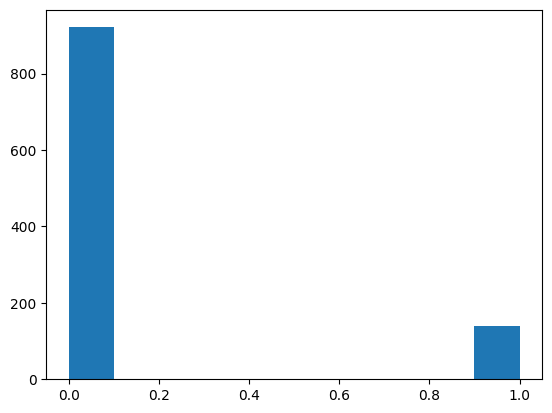

In [6]:
plt.hist(dat_nurse['outcome'])

In [7]:
# drop na (outcome na)
dat_nurse = dat_nurse[dat_nurse['outcome'].notnull()]
# train-test-split
train_dat, test_dat = train_test_split(dat_nurse, test_size = 0.15,  stratify=dat_nurse['outcome'], random_state=random_state)
# val_dat, test_dat = train_test_split(test_dat, test_size = 0.5, stratify=test_dat['outcome'], random_state=random_state)

In [8]:
# organizing data
clin_col = train_dat.columns[4:-10] # remove IDs, outcome, text
outcome_col = train_dat.columns[3]
text_col = train_dat.columns[-8:]

train_dat_clin, test_dat_clin = train_dat.loc[:, clin_col], test_dat.loc[:, clin_col]
train_dat_outcome, test_dat_outcome = train_dat.loc[:, outcome_col], test_dat.loc[:, outcome_col]
train_dat_text, test_dat_text = train_dat.loc[:, text_col], test_dat.loc[:, text_col]

In [9]:
train_doc = list(train_dat['TEXT'])
# val_doc = list(val_dat['TEXT'])
test_doc = list(test_dat['TEXT'])

In [10]:
train_y = train_dat_outcome.to_numpy()
# val_y = val_dat_outcome.to_numpy()
test_y = test_dat_outcome.to_numpy()

## **Pretrained Transformer**

In [11]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.8 MB/s eta 0:00:00


In [12]:
from transformers import AutoTokenizer, AutoModel
import torch

In [13]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
train_tokens = tokenizer(train_doc, padding=True, truncation=True, return_tensors="pt")

In [15]:
with torch.no_grad():
  train_outputs = model(**train_tokens)
  train_embeddings = train_outputs.last_hidden_state[:, 0, :].numpy()

In [16]:
test_tokens = tokenizer(test_doc, padding=True, truncation=True, return_tensors="pt")

In [17]:
with torch.no_grad():
  test_outputs = model(**test_tokens)
  test_embeddings = test_outputs.last_hidden_state[:, 0, :].numpy()

In [18]:
# SMOTE for imbalance
smote_tomek = SMOTETomek(random_state = random_state)
train_embeddings_resamp, train_y_resamp = smote_tomek.fit_resample(train_embeddings, train_y)
print(train_embeddings[train_y == 0].shape, train_embeddings[train_y == 1].shape)
print(train_embeddings_resamp[train_y_resamp == 0].shape, train_embeddings_resamp[train_y_resamp == 1].shape)

(783, 768) (118, 768)
(783, 768) (783, 768)


## **Modelling**

In [19]:
params = {
    'LogisticRegressionCV' : {
        'penalty' : ['l2']
    },
    'SVC' : {
        'kernel' : ['linear', 'poly', 'rbf'],
        'degree' : [3, 4, 5]
    },
    'GaussianProcessClassifier' : { # https://stackoverflow.com/questions/62755556/gaussian-process-regression-hyparameter-optimisation-using-python-grid-search
            "kernel": [RBF(l) for l in np.logspace(-1, 1, 20)]
        },
    'XGBClassifier' : { # got from some towardsdatascience article i forgot
            'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
            'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
            'max_depth': [5,6,7,8,9,10,11,12,13,14],
            'n_estimators': [50,65,80,100,115,130,150],
            'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            'eval_metric': ['auc'],
            'objective': ['binary:logistic']
    },
    'RandomForestClassifier': {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    }
}

In [20]:
def fit(x, y, parameters, n_iter, random_state = 42):
    """
    Randomized hyperparameter tuning for fitting models

    parameters:
        n_iter -- number of parameter settings sampled
    """
    print("Training LogisticRegressionCV:")
    lr = LogisticRegressionCV(max_iter = int(1e6))
    rs_lr = RandomizedSearchCV(lr, parameters['LogisticRegressionCV'], n_iter = n_iter, random_state=random_state)
    rs_lr.fit(x, y) 

    print("Training SVC:")
    svc = SVC(probability = True)
    rs_svc = RandomizedSearchCV(svc, parameters['SVC'], n_iter = n_iter, random_state=random_state)
    rs_svc.fit(x, y)

    print("Training GaussianProcessClassifier:")
    gp = GaussianProcessClassifier()
    rs_gp = RandomizedSearchCV(gp, parameters['GaussianProcessClassifier'], n_iter = n_iter, random_state=random_state)
    rs_gp.fit(x, y)

    print("Training XGBClassifier:")
    xgb = XGBClassifier()
    rs_xgb = RandomizedSearchCV(xgb, parameters['XGBClassifier'], n_iter = n_iter, random_state=random_state)
    rs_xgb.fit(x, y)

    print("Training RandomForestClassifier:")
    rf = RandomForestClassifier(random_state=random_state)
    rs_rf = RandomizedSearchCV(rf, parameters['RandomForestClassifier'], n_iter=n_iter, random_state=random_state)
    rs_rf.fit(x, y)

    models = [rs_lr, rs_svc, rs_gp, rs_xgb, rs_rf]
    return models


In [21]:
models = fit(train_embeddings_resamp, train_y_resamp, params, n_iter = 20, random_state = random_state)

Training LogisticRegressionCV:


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training SVC:


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training GaussianProcessClassifier:


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessin

Training XGBClassifier:
Training RandomForestClassifier:


In [22]:
for model in models:
    print(model.best_estimator_, model.best_params_, model.best_score_)

LogisticRegressionCV(max_iter=1000000) {'penalty': 'l2'} 0.9061374412405119
SVC(kernel='linear', probability=True) {'kernel': 'linear', 'degree': 3} 0.8901691052278139
GaussianProcessClassifier(kernel=RBF(length_scale=0.1)) {'kernel': RBF(length_scale=0.1)} 0.8774200769215117
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=130, n_jobs=None, num_parallel_tree=None,
              predictor=None, r

In [23]:
def evaluate(x, y, models):
    scores = {
        'ACC': [], 
        'AUC': [],
        'CMAT': []
    }
    for model in models:
        y_pred = model.predict(x)
        y_proba = model.predict_proba(x)[:, 1]
        scores['ACC'].append(accuracy_score(y, y_pred))
        scores['AUC'].append(roc_auc_score(y, y_proba))
        scores['CMAT'].append(confusion_matrix(y, y_pred))
        
    return scores 

In [24]:
evaluate(test_embeddings, test_y, models)

{'ACC': [0.7547169811320755,
  0.7295597484276729,
  0.7672955974842768,
  0.8176100628930818,
  0.8616352201257862],
 'AUC': [0.5355417529330573,
  0.5628019323671498,
  0.5824706694271912,
  0.6445824706694272,
  0.5250172532781229],
 'CMAT': [array([[118,  20],
         [ 19,   2]]),
  array([[115,  23],
         [ 20,   1]]),
  array([[119,  19],
         [ 18,   3]]),
  array([[130,   8],
         [ 21,   0]]),
  array([[137,   1],
         [ 21,   0]])]}